In [10]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src/')

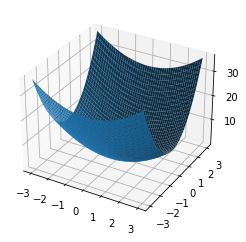

In [1]:
import numpy as np
import numpy.linalg as la

import scipy.optimize as sopt

import matplotlib.pyplot as pt
from mpl_toolkits.mplot3d import axes3d

def f(x):
    return x[0]**2 + 3.0*x[1]**2

def df(x):
    return np.array([2*x[0], 6*x[1]])

fig = pt.figure()
ax = fig.gca(projection="3d")

xmesh, ymesh = np.mgrid[-3:3:50j,-3:3:50j]
fmesh = f(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, fmesh)

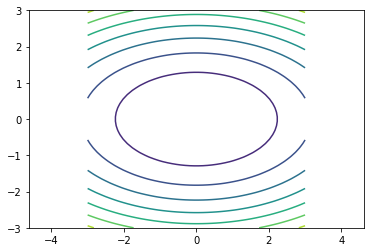

In [3]:
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh)
guesses = [np.array([2, 2./5])]

In [4]:
x = guesses[-1]
s = -df(x)

In [8]:
def f1d(alpha):
    return f(x + alpha*s)

alpha_opt = sopt.golden(f1d)
next_guess = x + alpha_opt * s
guesses.append(next_guess)
print(next_guess)

[ 0.69230769 -0.38461539]


Will test my own gradient functions now. A question is if autograd is robust enough. Will it always be the same? Can I define it once and then I get correct output no matter what input I feed it with?

In [15]:
from modelling import ols
theta = np.random.randn(2,1)
n = 1000
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]

In [16]:
ols.analytical_cost_grad(X,y,theta)

array([[-16.35533371],
       [-18.79492916]])

In [32]:
gradient = ols.auto_cost_grad()
gradient(X,y,theta)

array([[-16.35533371],
       [-18.79492916]])

In [36]:
theta2 = ols.update_beta_sgd(X,y,theta,gradient)
theta3 = ols.update_beta_sgd(X,y,theta,gradient)

In [37]:
print(theta2)
print(theta3)

[[-0.3060813 ]
 [-0.92984812]]
[[-0.3060813 ]
 [-0.92984812]]


So autograd works perfectly.

In [43]:
np.random.randint(10)

6

So one gradient descent step is subtracting the sum of the gradient across the whole batch. That is, a gradient is calculated at each xi, and added together. This sum is then multiplied by learning rate, and then beta is subtracted this value. 
So each batch, sum gradient over it. Then repeat this m=n/batch_size number of times, so that you've 'touched' n data points. This is one runthrough. Repeat this n_epochs number of times.

It is advised to shuffle the data to avoid spurius correlations due to the way the data is presented. Should one shuffle on each gradient step?

So at each gradient descent step, a batch is chosen at random. But is the data divided up into batches beforehand?

In [45]:
from data.create_dataset import *
from visualization.visualize import *
from modelling import ols,ridge
from model_evaluation.metrics import *
from processing.data_preprocessing import *
from utils.utils import *
import numpy as np
from sklearn.model_selection import  train_test_split

In [49]:
beta_regular = ols.fit_beta(X,y)
beta_regular

array([[3.98013708],
       [2.98759418]])

When experimenting with batch size it seems that having batch_size=n is much faster than batch_size=1. Aparently this is the case for convex cost functions, which our cost function is. But why that's the case is unclear.

In [135]:
beta = ols.fit_beta_sgd(X,y,0.01,100,100)

In [136]:
beta

array([[3.92116841],
       [3.02605619]])

So when increasing epochs enough the sgd method is able to reach similar solution as regular regression, however much much slower. There might be room for improvement by increasing batch size for instance(because, remember vectorized code may run much quicker(SIMD))

In [137]:
from sklearn.linear_model import SGDRegressor
sgdreg = SGDRegressor(max_iter = 100, penalty=None, eta0=0.01, tol=None)
sgdreg = sgdreg.fit(x,y.ravel())

In [138]:
sgdreg.coef_

array([2.98961663])

In [139]:
sgdreg.intercept_

array([3.98158177])

In [141]:
np.mean(y) - np.mean(X,axis=0)@beta

array([0.02110411])

In [116]:
from sklearn.utils import shuffle
a = np.arange(0,10)
c = np.column_stack((a,a,a))
b = np.arange(0,10).reshape(-1,1)
shuffle(c,b)

[array([[5, 5, 5],
        [9, 9, 9],
        [3, 3, 3],
        [4, 4, 4],
        [2, 2, 2],
        [6, 6, 6],
        [8, 8, 8],
        [7, 7, 7],
        [1, 1, 1],
        [0, 0, 0]]),
 array([[5],
        [9],
        [3],
        [4],
        [2],
        [6],
        [8],
        [7],
        [1],
        [0]])]

sklearns shuffle can be used to shuffle between every epoch.

How is scaling affecting the regression? Is the intercept fitted correctly? How should the intercept be fitted with SGD? One way is to again center the data, calculate beta, and then add intercept back in again. It would be the same as regular OLS, though the fitting procedure is different.

In [144]:
from numpy import c_,zeros
c_[zeros(c.shape[0]),c]

array([[0., 0., 0., 0.],
       [0., 1., 1., 1.],
       [0., 2., 2., 2.],
       [0., 3., 3., 3.],
       [0., 4., 4., 4.],
       [0., 5., 5., 5.],
       [0., 6., 6., 6.],
       [0., 7., 7., 7.],
       [0., 8., 8., 8.],
       [0., 9., 9., 9.]])

In [161]:
beta = ols.fit_beta_sgd(X,y,0.01,100,100)
beta

array([[3.98419312],
       [2.97853722]])

In [149]:
np.insert(a,0,20)

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])